In [1]:
import os
import warnings

import json
import pandas as pd
import seaborn as sns
import numpy as np

from stress_slurm import config

In [2]:
def assert_count(expected: int, path: str):
    real = len(list(os.scandir(scenario_path))) - 1
    if not (expected == real):
        warnings.warn(f"Expected {expected} result files but only found {real} at {path}", DeprecationWarning)

In [3]:
RESULT_PATH = config.RESULTS_FOLDER_PATH + "/scenarios/"
SAVE_PATH = RESULT_PATH + "/graphs/"
SCENARIOS = [
    "1-LOSO_15real",
    "2-TSTR_15syn",
    "3-TSTR_cGAN",
    "4-LOSO_cGAN",
    "5-LOSO_15real_noised",
    "6-LOSO_cGAN_priv",
]

1-LOSO_15real
          model   eps        f1       std
0           CNN   0.1  0.283188  0.000000
1   Transformer   0.1  0.588123  0.000000
2      CNN-LSTM   0.1  0.716972  0.000000
3           CNN   1.0  0.268202  0.000000
4   Transformer   1.0  0.583147  0.000000
5      CNN-LSTM   1.0  0.718152  0.000000
6           CNN  10.0  0.462108  0.000928
7   Transformer  10.0  0.598131  0.000000
8      CNN-LSTM  10.0  0.731813  0.000267
9   Transformer   inf  0.810849  0.021341
10     CNN-LSTM   inf  0.864287  0.012821
11          CNN   inf  0.877057  0.008523
2-TSTR_15syn
       gan        model        f1       std
0  TIMEGAN     CNN-LSTM  0.716972  0.000000
1  TIMEGAN          CNN  0.716972  0.000000
2  TIMEGAN  Transformer  0.717471  0.001579
3     DGAN  Transformer  0.805989  0.038304
4     DGAN     CNN-LSTM  0.853336  0.018172
5     DGAN          CNN  0.858933  0.015532
6     CGAN  Transformer  0.870440  0.021278
7     CGAN          CNN  0.885022  0.015874
8     CGAN     CNN-LSTM  0.9023

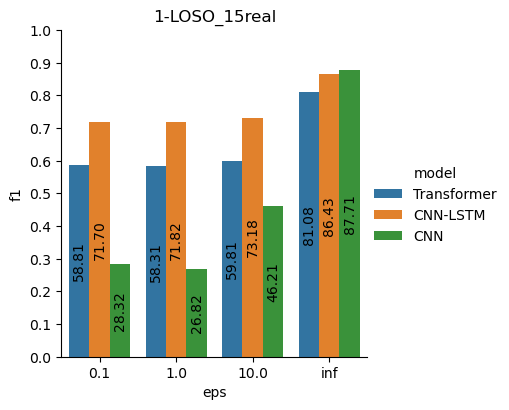

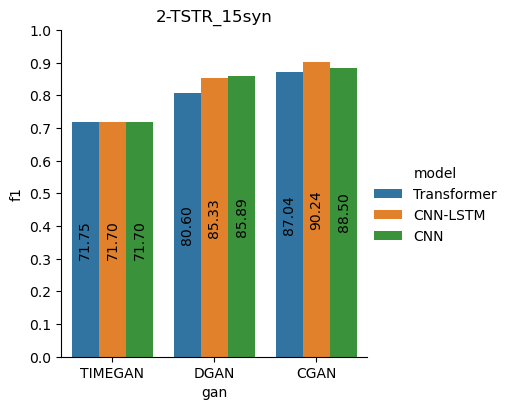

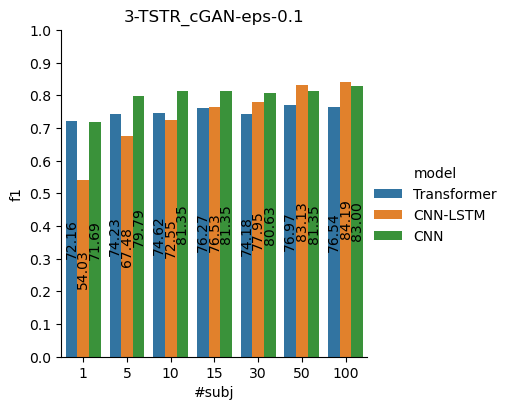

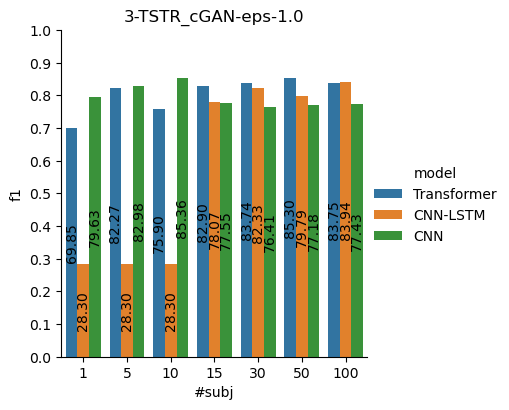

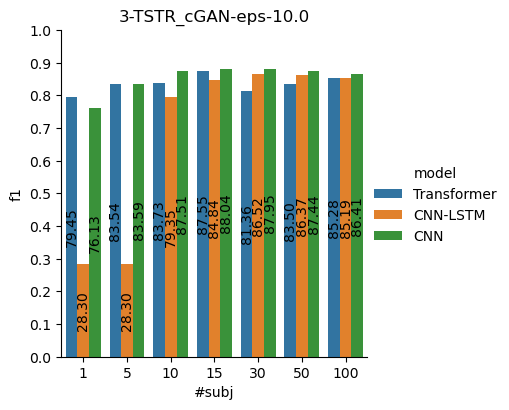

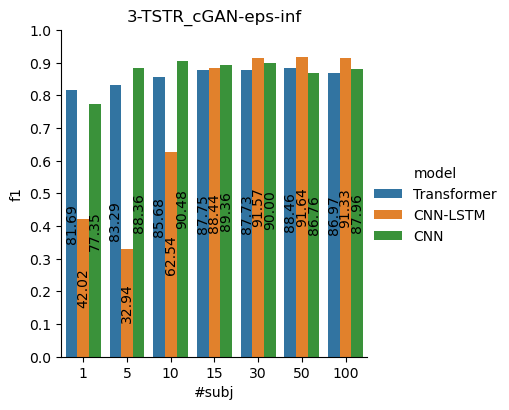

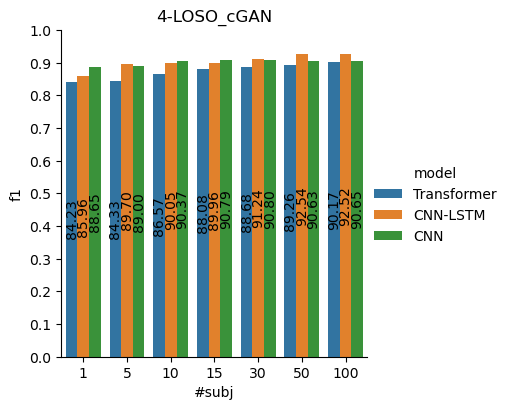

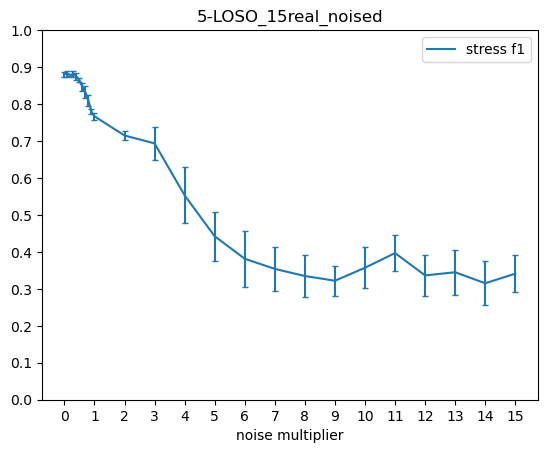

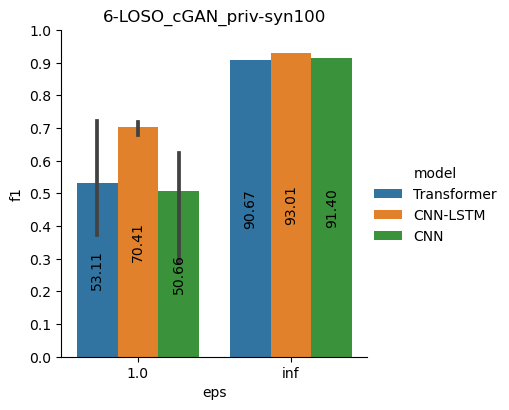

In [9]:
# columns: acc+std rec+std prec+std f1+std unusable
for scenario in SCENARIOS:
    scenario_path = RESULT_PATH + scenario
    result_list = []
    for filename in os.scandir(scenario_path):
        if filename.is_file():
            with open(filename.path) as json_file:
                data = json.load(json_file)
                result_list.append(data)
                
    print(scenario)
    plotTitle = scenario
    hue_order = ['Transformer', 'CNN-LSTM', 'CNN']
    na_value = np.inf
    ax = None
                
    if scenario == "1-LOSO_15real":
        assert_count(expected=(3*4), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["train_config"]["nn_mode"],
             res["privacy_config"]["eps"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =["model", 'eps', 'f1', 'std']).fillna(na_value).sort_values(["eps", "f1"]).reset_index(drop=True)
        print(df)
        
        g = sns.catplot(
            x="eps",       # x variable name
            y="f1",       # y variable name
            hue="model",  # group variable name
            hue_order=hue_order,
            data=df,     # dataframe to plot
            kind="bar",
            height=4,
        )
        
        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{(v.get_height()*100):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', rotation=90)
        
        g.set(title=plotTitle if plotTitle else None, yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + '.pdf')
        
    if scenario == "2-TSTR_15syn":
        assert_count(expected=(3*3), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["gan_config"]["gan_mode"],
             res["train_config"]["nn_mode"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['gan', 'model', 'f1', 'std']).sort_values(["f1"]).reset_index(drop=True)
        print(df)
        
        g = sns.catplot(
            x="gan",
            y="f1",
            hue="model",  # group variable name
            hue_order=hue_order,
            data=df,     # dataframe to plot
            kind="bar",
            height=4,
        )
        
        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{(v.get_height()*100):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', rotation=90)
            
        g.set(title=plotTitle if plotTitle else None, yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + '.pdf')
        
    if scenario == "3-TSTR_cGAN":
        assert_count(expected=(3*4*7), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["syn_subj_cnt"],
             res["gan_config"]["eps"],
             res["train_config"]["nn_mode"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['#subj', 'eps', 'model', 'f1', 'std']).fillna(na_value).sort_values(["#subj", "eps", "f1"]).reset_index(drop=True)
        print(df)
        
        groups = df.groupby("eps")
        for group_name, group_df in groups:
            g = sns.catplot(
                x="#subj",
                y="f1",
                hue="model",  # group variable name
                hue_order=hue_order,
                data=group_df,     # dataframe to plot
                kind="bar",
                height=4,
            )
            
            # extract the matplotlib axes_subplot objects from the FacetGrid
            ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

            # iterate through the axes containers
            for c in ax.containers:
                labels = [f'{(v.get_height()*100):.2f}' for v in c]
                ax.bar_label(c, labels=labels, label_type='center', rotation=90)
            
            g.set(title=plotTitle+"-eps-"+str(group_name) if plotTitle else None, yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + "-eps-" + str(group_name) + '.pdf')
            
    if scenario == "4-LOSO_cGAN":
        assert_count(expected=(3*7), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["syn_subj_cnt"],
             res["train_config"]["nn_mode"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['#subj', 'model', 'f1', 'std']).sort_values(["#subj", "f1"]).reset_index(drop=True)
        print(df)
        
        g = sns.catplot(
            x="#subj",
            y="f1",
            hue="model",  # group variable name
            hue_order=hue_order,
            data=df,     # dataframe to plot
            kind="bar",
            height=4,
        )
        
        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{(v.get_height()*100):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', rotation=90)
            
        g.set(title=plotTitle if plotTitle else None, yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + '.pdf')
    
    if scenario == "5-LOSO_15real_noised":
        assert_count(expected=(1*(10+10+5)), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["train_config"]["data_noise_parameter"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['noise multiplier', 'stress f1', 'std']).sort_values("noise multiplier").reset_index(drop=True)
        print(df)
        df.plot(
            kind='line',
            x='noise multiplier',
            y='stress f1',
            yerr='std',
            capsize=2,
            title=plotTitle if plotTitle else None,
            yticks=[round(i * 0.1, 1) for i in range(0, 10+1)],
            xticks=[float(i) for i in range(0, 15+1)],
        ).get_figure().savefig(SAVE_PATH + scenario + '.pdf')
        
        
    if scenario == "6-LOSO_cGAN_priv":
        assert_count(expected=(3*4*1), path=scenario_path)
        df_data = []
        [df_data.append(
            [res["syn_subj_cnt"],
             res["gan_config"]["eps"],
             res["train_config"]["nn_mode"],
             res["results"]["mean"]["average"]["f1"],
             res["results"]["std"]["average"]["f1"]
            ]) for res in result_list]
        
        df = pd.DataFrame(df_data, columns =['#subj', 'eps', 'model', 'f1', 'std']).fillna(na_value).sort_values(["#subj", "eps", "f1"]).reset_index(drop=True)
        print(df)
        
        # groups = df.groupby("eps")
        # for group_name, group_df in groups:
        #     sns.catplot(
        #         x="#subj",
        #         y="f1",
        #         hue="model",  # group variable name
        #         hue_order=hue_order,
        #         data=group_df,     # dataframe to plot
        #         kind="bar",
        #         height=4,
        #     ).set(title=plotTitle+"-eps-"+str(group_name), yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + '.pdf')
        
        g = sns.catplot(
            x="eps",
            y="f1",
            hue="model",  # group variable name
            hue_order=hue_order,
            data=df,     # dataframe to plot
            kind="bar",
            height=4,
        )
        
        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{(v.get_height()*100):.2f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='center', rotation=90)
            
        g.set(title=plotTitle+"-syn100" if plotTitle else None, yticks=[round(i * 0.1, 1) for i in range(0, 10+1)]).figure.savefig(SAVE_PATH + scenario + '.pdf')
        